In [12]:
import seaborn as sns

sns.set_theme(
    rc={"axes.spines.top": False, "axes.spines.right": False, "figure.autolayout": True},
    style="ticks",
)

%matplotlib inline

# Plotting simulations & residuals spectra

Simulations and data as well as covariance are stored as `sacc` objects. For more details regarding `sacc` format, you can have a look to the tutorial [notebooks](https://github.com/LSSTDESC/sacc/tree/master/examples) or you can refer to the official [documentation](https://sacc.readthedocs.io/en/latest/). Here we will read the power spectra for all the simulations and compare its mean value to theory + foregrounds (without and with systematics). As we will see, **the content of each spectrum (multipole range, spectra, associated covariance...) is stored within the `spec_meta` attribute of `MFLike`**. In this tutorial, we will see how to dig into this attribute to plot simulated data against models.


We first start by using the likelihood declaration from the first [tutorial](tutorial_loading.ipynb)

In [1]:
%run tutorial_loading.ipynb

     Numpy : 1.26.4
Matplotlib : 3.8.2
      CAMB : 1.5.4
    Cobaya : 3.4.1
[install] Installing external packages at '/tmp/LAT_packages'


hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).



likelihood:mflike.MFLike

[install] Checking if dependencies have already been installed...
[install] External dependencies for this component already installed.
[install] Doing nothing.

* Summary * 

[install] All requested components' dependencies correctly installed at /tmp/LAT_packages
[camb] `camb` module loaded successfully from /home/serenagiardiello/anaconda3/envs/mflike/lib/python3.10/site-packages/camb
[mflike.mflike] Number of bins used: 3087
[mflike.mflike] Initialized!


In [2]:
mflike_input_file = dict(
    input_file="LAT_simu_sacc_00044.fits", cov_Bbl_file="data_sacc_w_covar_and_Bbl.fits",
    python_path= "/home/serenagiardiello/Desktop/SO/band_int/codes/LAT_MFLike_sgiardie" 
)
mflike_config = {"mflike.MFLike": mflike_input_file}

import os
import tempfile

from cobaya.install import install

packages_path = os.path.join(tempfile.gettempdir(), "LAT_packages")
install({"likelihood": mflike_config}, path=packages_path, no_set_global=True, skip_global=True)

cosmo_params = {
    "cosmomc_theta": 0.0104092,
    "As": 1e-10 * np.exp(3.044),
    "ombh2": 0.02237,
    "omch2": 0.1200,
    "ns": 0.9649,
    "Alens": 1.0,
    "tau": 0.0544,
}

fg_params = {
    "a_tSZ": 3.30,
    "a_kSZ": 1.60,
    "a_p": 6.90,
    "beta_p": 2.20,
    "a_c": 4.90,
    "beta_c": 2.20,
    "a_s": 3.10,
    "T_d": 9.60,
    "a_gtt": 2.80,
    "a_gte": 0.10,
    "a_gee": 0.10,
    "a_psee": 0.003,
    "a_pste": 0.042,
    "xi": 0.10,
    "beta_s": -2.5,  # beta radio
    "alpha_s": 1,  # alpha radio
    "T_effd": 19.6,  # effective galactic dust temperature
    "beta_d": 1.5,  # beta galactic dust
    "alpha_dT": -0.6,  # galactic dust ell slope for T
    "alpha_dE": -0.4,  # galactic dust ell slope for E
    "alpha_p": 1,  # CIB poisson ell slope
}

nuisance_params = {
    # only ideal values for now
    "bandint_shift_LAT_93": 0,
    "bandint_shift_LAT_145": 0,
    "bandint_shift_LAT_225": 0,
    "calT_LAT_93": 1,
    "calE_LAT_93": 1,
    "calT_LAT_145": 1,
    "calE_LAT_145": 1,
    "calT_LAT_225": 1,
    "calE_LAT_225": 1,
    "cal_LAT_93": 1,
    "cal_LAT_145": 1,
    "cal_LAT_225": 1,
    "calG_all": 1,
    "alpha_LAT_93": 0,
    "alpha_LAT_145": 0,
    "alpha_LAT_225": 0,
}

minimal_settings = dict(lens_potential_accuracy=1)

high_accuracy_settings = dict(
    lens_potential_accuracy=8,
    lens_margin=2050,
    AccuracyBoost=2.0,
    lSampleBoost=2.0,
    lAccuracyBoost=2.0,
    kmax=10,
    k_per_logint=130,
    nonlinear=True,
    DoLateRadTruncation=False,
)

info = {
    "params": cosmo_params | fg_params | nuisance_params,
    "likelihood": mflike_config,
    "theory": {"camb": {"extra_args": minimal_settings}},
    "packages_path": packages_path,
}

from cobaya.model import get_model

model = get_model(info)

mflike = model.likelihood["mflike.MFLike"]

[install] Installing external packages at '/tmp/LAT_packages'

likelihood:mflike.MFLike

[install] Checking if dependencies have already been installed...
[install] External dependencies for this component already installed.
[install] Doing nothing.

* Summary * 

[install] All requested components' dependencies correctly installed at /tmp/LAT_packages
[camb] `camb` module loaded successfully from /home/serenagiardiello/anaconda3/envs/mflike/lib/python3.10/site-packages/camb
[mflike.mflike] Number of bins used: 3087
[mflike.mflike] Initialized!


As we did in the foreground [tutorial](tutorial_foregrounds.ipynb), we first get the theory spectra

In [3]:
model.logposterior({})
dls = model.theory["camb"].get_Cl(ell_factor=True)

[mflike.mflike] Computing bandpass at first step, no shifts


To take into account the systematics, we call the `mflike.ThFo.get_modified_theory` function. In this function, we need to use the same $\ell$ range set by the data through the variable `l_bpws`, that is why we generated the theory spectra using the `mflike.l_bpws` ell range. (Notice that `dls` has a multipole range of `2, mflike.l_bpws[-1]`).

In [4]:
ell = mflike.l_bpws
dls_cmb = {mode: dls[mode][ell] for mode in ["tt", "te", "ee", "bb"]}
dl_obs = mflike.ThFo.get_modified_theory(dls_cmb, **fg_params, **nuisance_params)

There would be a difference between theory, foreground and the total spectra modified by the systematics once some of the `nuisance_parameters` are set to a non-ideal value.

## Simulated data *vs.* data model

We start by plotting unbinned theory + foreground model with the total power spectrum modified by the systematics for a bunch of simulated files. Let's first start by retrieving the foreground model

In [5]:
fg_models = mflike.ThFo._get_foreground_model(ell=ell, **fg_params)

To load `MFLike` for different simulated data file, we will use the external way as described in the last part of this [tutorial](tutorial_logp_value.ipynb). Altough the `spec_meta` attribute holds the different spectra, there is no easy way to extract a specific cross and/or mode. Here we will built a dictionnary indexed on spectrum mode and cross experiments to be latter used by the plotting function (the `contextmanager` is just to catch and flush the `logging` messages when initializing `MFLike` likelihood)

In [6]:
import logging
from contextlib import contextmanager

from mflike import MFLike
from tqdm.auto import tqdm


@contextmanager
def disable_logging(highest_level=logging.CRITICAL):
    previous_level = logging.root.manager.disable
    logging.disable(highest_level)
    try:
        yield
    finally:
        logging.disable(previous_level)


nsims = 10
dls_sims = {}
for isim in tqdm(range(nsims)):
    input_file = dict(input_file=f"LAT_simu_sacc_{isim:05d}.fits")
    with disable_logging():
        ext_mflike = MFLike(mflike_input_file | input_file, packages_path=packages_path)
        for data in ext_mflike.spec_meta:
            lb, db = data.get("leff"), data.get("cl_data")
            cross = (data.get("t1"), data.get("t2"))
            mode = data.get("pol") if not data.get("hasYX_xsp") else "et"
            dls_sims.setdefault((mode, *cross), []).append([lb, db])

/home/serenagiardiello/anaconda3/envs/mflike/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|████████████████████████████████████████████████████████████████| 10/10 [00:21<00:00,  2.14s/it]


Finally, we can plot the different simulated spectra on top of the CMB expectation + the foreground model

In [7]:
import matplotlib.pyplot as plt


def plot_simulation(*cross):
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    for mode, ax in zip(["tt", "ee", "te", "et"], axes.flatten()):
        if not (dls_sim := dls_sims.get((mode, *cross))):
            fig.delaxes(ax)
            continue
        ax.legend([], title="{} - {}x{}".format(mode.upper(), *cross))
        if mode == "tt":
            ax.set(yscale="log", ylim=(0.1, 10_000))

        mode = "te" if mode == "et" else mode
        for lb, db in dls_sim:
            ax.plot(lb, db, "gray")
        ax.plot(ell, dls_cmb[mode], "-r", label="theory")
        ax.plot(ell, fg_models[mode, "all", cross[0], cross[1]], "-b", label="all foregrounds")
        ax.plot(ell, dl_obs[mode, cross[0], cross[1]], "-g", lw=2, label="theory + FG with systematics")
        ax.plot(*np.mean(dls_sim, axis=0), "--k", label="mean sim.")

    fig.supxlabel(r"$\ell$")
    fig.supylabel(r"$D_\ell$")
    fig.legend(*axes[0, 0].get_legend_handles_labels(), bbox_to_anchor=(1.3, 1));

In [13]:
plot_simulation("LAT_93", "LAT_93")

<Figure size 1000x800 with 0 Axes>

In [14]:
plot_simulation("LAT_93", "LAT_145")

<Figure size 1000x800 with 0 Axes>

## Plotting residuals

Given a simulation file, we will loop over the content of `MFLike.spec_meta` attribute to plot the residuals *i.e.* simulations - (theory + foregrounds with possible systematics) for the different spectra and cross frequencies. The bandpower weights are stored within the `bpw` field of `spec_meta` and we use it to bin the theory and foregrounds spectra

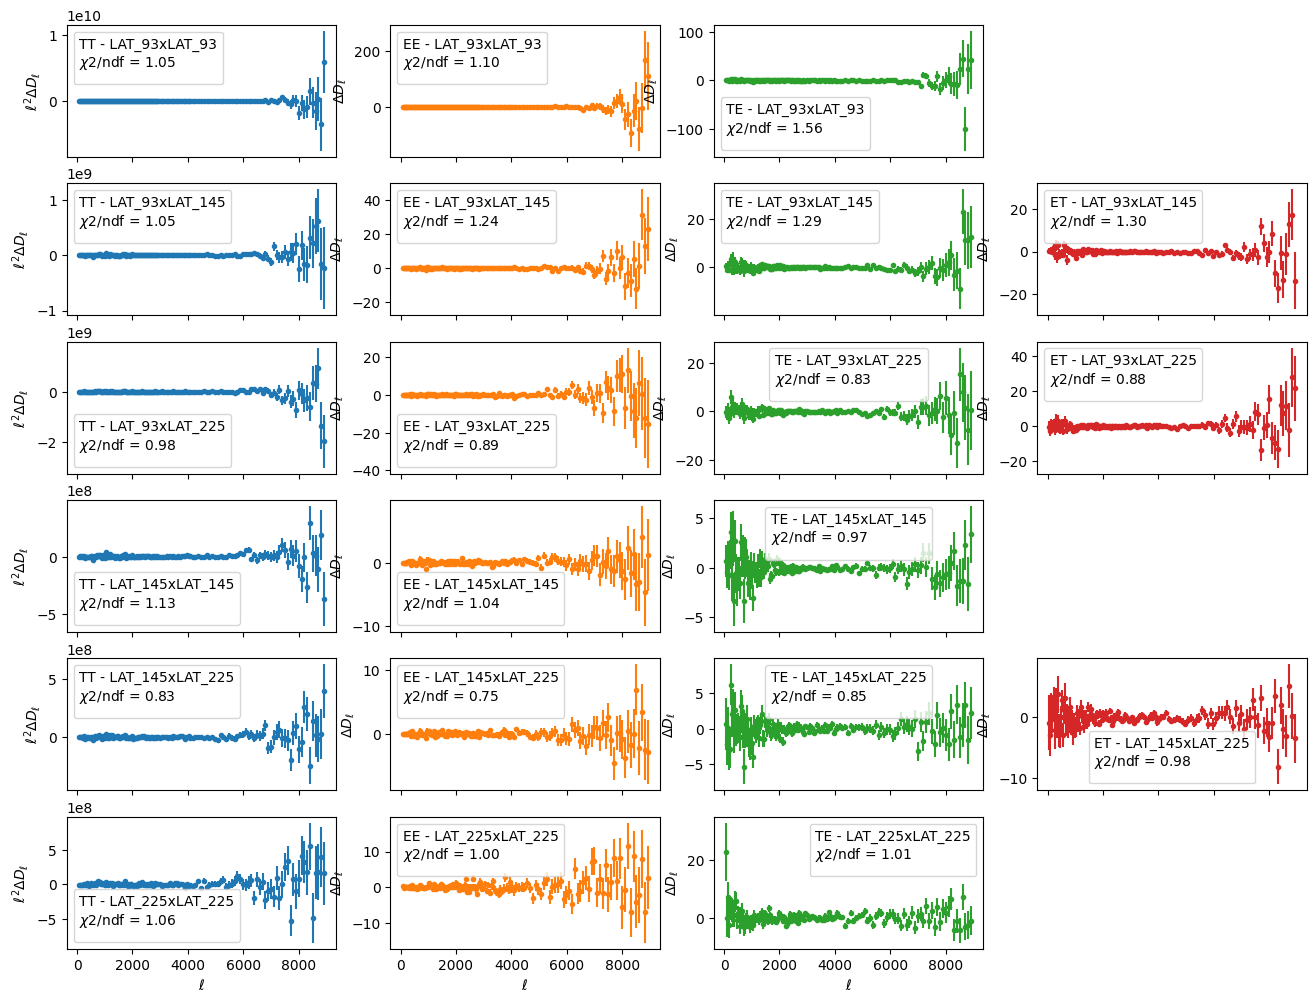

In [9]:
from itertools import combinations_with_replacement as cwr

modes = ["TT", "EE", "TE", "ET"]

experiments = mflike.experiments
crosses = list(cwr(experiments, 2))
fig, axes = plt.subplots(len(crosses), 4, sharex=True, figsize=(16, 2 * len(crosses)))

for data in mflike.spec_meta:

    # Data/simulation
    lb = data.get("leff")
    db = data.get("cl_data")
    ids = data.get("ids")
    cov = mflike.cov[np.ix_(ids, ids)]
    db_err = np.sqrt(np.diag(cov))

    # Fit
    cross = (data.get("t1"), data.get("t2"))
    db_fit = dl_obs[data.get("pol"), cross[0], cross[1]] @ data["bpw"].weight
    delta_db = db - db_fit

    irow = crosses.index(cross)
    mode = data.get("pol") 
    icol = modes.index(mode)
    ax = axes[irow, icol]
    if mode == "TT":
        ax.errorbar(lb, lb**2 * delta_db, lb**2 * db_err, fmt=f".C{icol}")
    else:
        ax.errorbar(lb, delta_db, db_err, fmt=f".C{icol}")

    chi2 = delta_db @ np.linalg.inv(cov) @ delta_db
    title = "{} - {}x{}\n$\chi2$/ndf = {:.2f}".format(mode.upper(), *cross, chi2 / len(delta_db))
    ax.legend([], title=title)

# Remove empty axes
for ax in axes.flatten():
    if not ax.lines:
        fig.delaxes(ax)
for ax in axes[:, 0]:
    ax.set_ylabel(r"$\ell^2\Delta D_\ell$")
for ax in axes[:, 1:].flatten():
    ax.set_ylabel(r"$\Delta D_\ell$")
for ax in axes[-1]:
    ax.set_xlabel(r"$\ell$")

Notice that here the difference between simulations and the (theory+foreground) spectra with possible systematics is mainly driven by the different foreground model adopted by the code